# **CVPS20 // Midterm (GGD: Total = 54 / 55)**

assigned : **Oct 8, 2020**

DUE : **Oct 8, 2020 11:59pm**

## Using Satellite Images to Assess Smoke Cover from California Wildfires

---

In this notebook you will use a satellite image of California from September 2020 to determine several characteristics of the resultant smoke cover from wildfires in the state.  Analyses like this help first responders and policy makers quickly assess needs and guide distribution of resources, especially with the inclusion of supplemental information including census counts of residents and locations of individual cities/towns.

*NOTE: this midterm is not timed, but it is designed to take roughly 1.25 hr to complete.*

<b>

<u>*PLEASE EDIT THIS NOTEBOOK DIRECTLY, DO NOT MAKE A COPY AND THEN SHARE THAT WITH ME.*</u>

Rules for the midterm:

1. You may <u>not</u> work with anyone else on this midterm.  Doing so will result in a violation of the *University of Delaware*'s Academic Code of Conduct (see [syllabus](https://cvps20.slack.com/#syllabus)).  Direct copying from someone else's notebook is not permitted.

2. You <u>may</u> use any other resource available to you including class notebooks, homework solution notebooks, slides, videos, stackoverflow, *etc*.

3. All solutions and outputs must be derived with python and the notebook should be "runable" by me (top to bottom) without errors.

</b>

<u>**Instructions for tasks that will be graded are in bold below.**</u>

---

**By adding your name to the box below you declare that the work in this midterm was done by you, that you did not work with anyone else (either a student in this class or otherwise), that you did not share your solutions with anyone, and that you did not receive solutions from anyone.**

Ming Lian

---

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
from skimage.filters import threshold_otsu
from scipy.signal import convolve2d
from scipy import ndimage
import math

In [21]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["image.cmap"] = "gist_gray"
plt.rcParams["image.interpolation"] = "nearest"

**Read in the file `california_wildfires_3clr.png` (in the folder in which you opened this notebook) using `imageio` and be sure to convert it to a numpy array with values between `0` and `1`.  Display the image. (GGD: -1 [did not convert to `numpy` array)**


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-23-2f300251ed61>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  Image = iio.imread('/content/drive/My Drive/CVPS20/data/examples/california_wildfires_3clr.png')


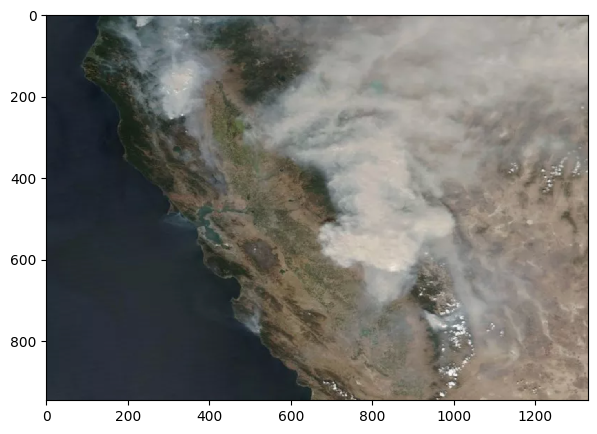

In [23]:
Image = iio.imread('/content/drive/My Drive/CVPS20/data/examples/california_wildfires_3clr.png')

Image = Image/255

plt.imshow(Image)

**Create a luminosity image by taking the mean across the color channels.**

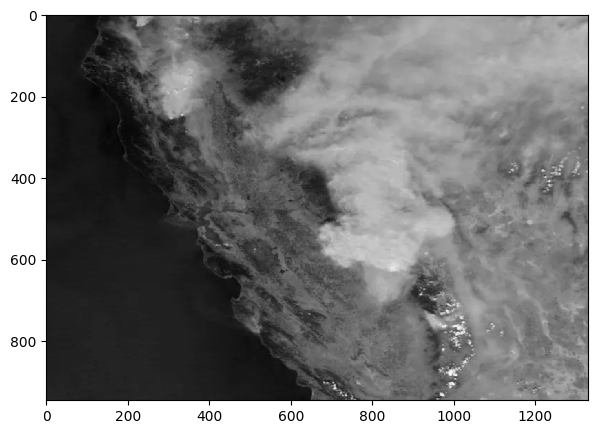

In [24]:
Lum = np.mean(Image, 2)
plt.imshow(Lum)

**Seprate the red, green, and blue color channels into their own (2D) arrays and make a 4-panel plot of the luminosity image, the red channel, the green channel, and the blue channel.**

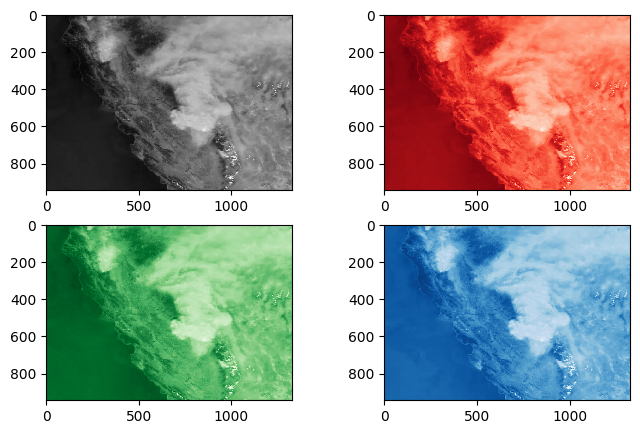

In [25]:
Red = Image[:, :, 0]
Green = Image[:, :, 1]
Blue = Image[:, :, 2]

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(Lum)
ax[0, 1].imshow(Red , cmap="Reds_r")
ax[1, 0].imshow(Green, cmap="Greens_r")
ax[1, 1].imshow(Blue, cmap="Blues_r")
fig.show()

<b>

Using Otsu's method,

1. calculate the Otsu threshold for the luminosity image;
2.  plot a histogram of pixel values for the luminosity image and overplot the value of the Otsu threshold as a vertical line;
3. display the Otsu thresholded image.

</b>

Text(0, 0.5, 'number of pixels')

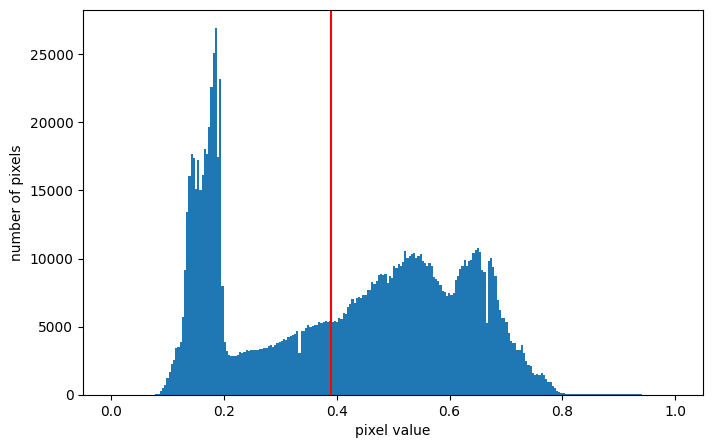

In [26]:
Thresh = threshold_otsu(Lum)

plt.hist(Lum.flatten(), bins = 256, range = [0,1])
plt.axvline(Thresh, color = 'r')
plt.xlabel("pixel value")
plt.ylabel("number of pixels")

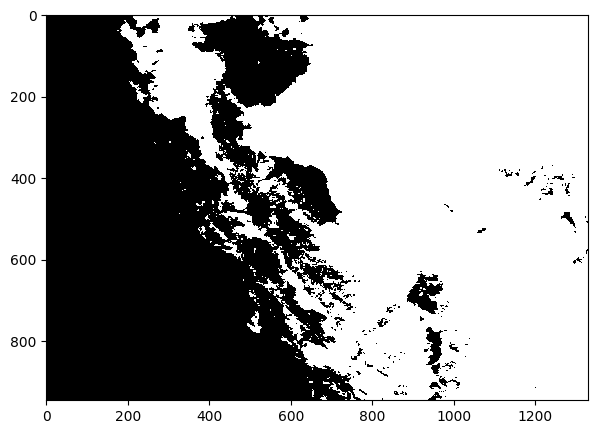

In [27]:
plt.imshow(Lum>Thresh)

Notice that the Otsu threshold does not does not effectively isolate the pixels that have smoke cover.

**Choose a different threshold value that isolates the smoke pixels in the image and <u>justify your choice</u> (*in words*).**

* **A better threshold should be around 0.6, as the smoke parts are mostly with high luminocity, and there is a prominent peak above 0.6.**

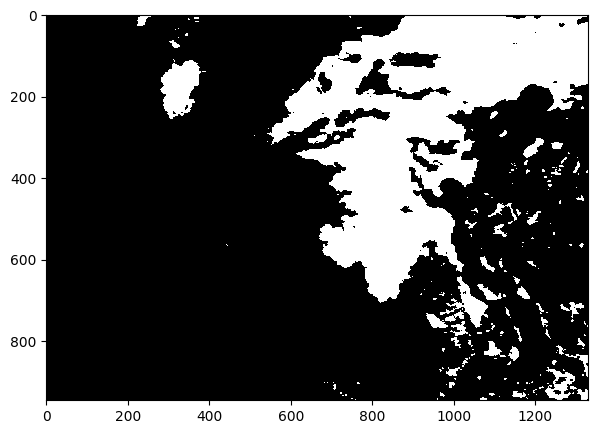

In [28]:
LumBi = Lum>0.6
plt.imshow(LumBi)

**Assuming that the area of each pixel is $0.12$ square miles, how many total square miles are covered by smoke in this image?**

In [29]:
#Count the number of the pixels

NoPixel = sum(sum(Lum>0.6))

Area = 0.12 * NoPixel

print('There are about {0} square miles of smoke.'.format(Area))

There are about 33355.56 square miles of smoke.


**Given the fact that the upper left corner of the image has $(x, y) = (-125.04^{\circ}, 41.25^{\circ})$ and the lower right corner has $(x, y) = ( -116.20^{\circ}, 35.00^{\circ})$, is the town of Covelo at $(-123.25^{\circ}, 39.80^{\circ})$ underneath smoke cover?$^{\dagger}$**

<small> $^{\dagger}$ NOTE: if you get an error `"IndexError: only integers, slices (:), ellipsis (...), numpy.newaxis (None) and integer or boolean arrays are valid indices"`, it means that you must convert your row and column numbers to integers.

In [30]:
XRelative = (-123.25 - -125.04)/(-116.2 - -125.04)
YRelative = (39.8 - 41.25)/( 35 - 41.25)

X = round(Image.shape[1] * XRelative)
Y = round(Image.shape[0] * YRelative)


In [31]:
if LumBi[Y,X] == True:
  print('The town of Covelo is underneath smoke')
else:
  print('The town of Covelo is not underneath smoke')

The town of Covelo is not underneath smoke


<b>

Find the boundaries of the smoke clouds by:

1. Converting your thresholded luminosity image to float (i.e., `0.0`'s and `1.0`'s instead of `True`'s and `False`'s);

2. gaussian filter the result of 1;

3. apply a Sobel filter to the result of 2.

Make sure to <u>justify your choice</u> (*in words*) for the filter width in step 2.

</b>

In [32]:
LumFloat = LumBi.astype(float)

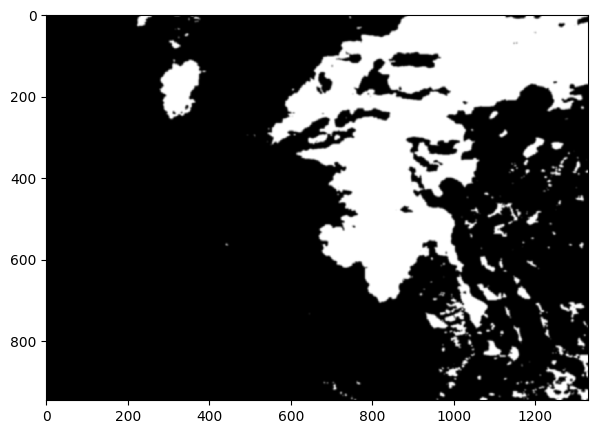

In [76]:
LumFloatGau = ndimage.gaussian_filter(LumFloat, sigma=2)
plt.imshow(LumFloatGau)

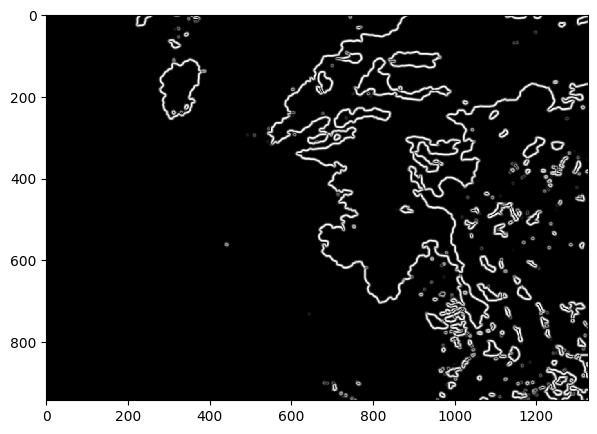

In [34]:
# -- define the Sobel filters
sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

Lx = convolve2d(LumFloatGau, sx)
Ly = convolve2d(LumFloatGau, sy)
LL = np.sqrt(Lx**2 + Ly**2)

plt.imshow(LL[2:-2, 2:-2])

* **The filter makes the boundaries continuous and clear without loosing much details, hence a proper choice.**

In [101]:
from numpy.lib.index_tricks import ndindex
tshirt = plt.imread('/content/drive/MyDrive/Colab Notebooks/20200209_000729.jpg')
tshirtLum = tshirt.mean(axis=-1)
tshirtGau = ndimage.gaussian_filter(tshirt, 3)
tshirtLumGau = ndimage.gaussian_filter(tshirtLum, 3)

In [102]:
tshirtGau.shape

(2111, 2111, 3)

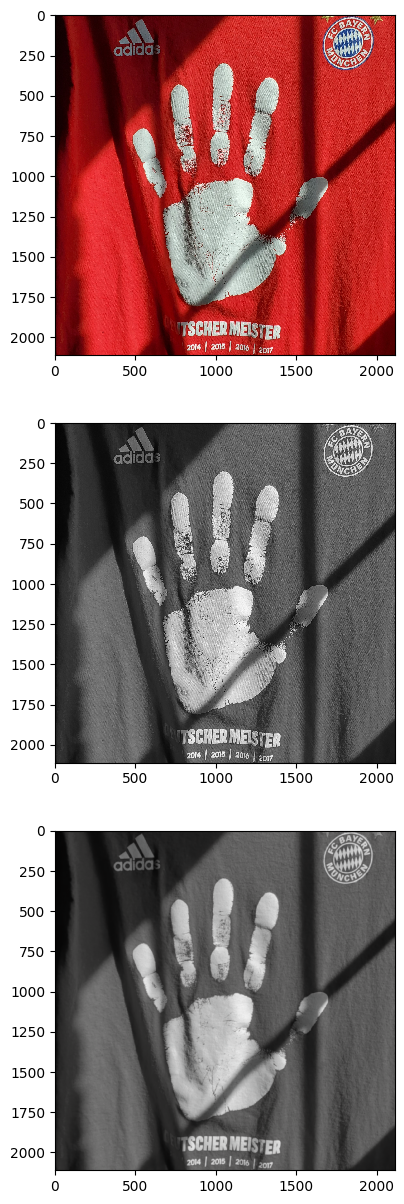

In [103]:
fig, ax = plt.subplots(3,1, figsize=(5,15))
ax[0].imshow(tshirt)
ax[1].imshow(tshirtLum)
ax[2].imshow(tshirtGau)

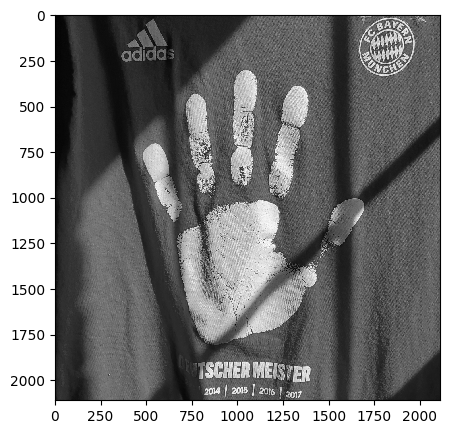

In [104]:
plt.imshow(tshirtLum)

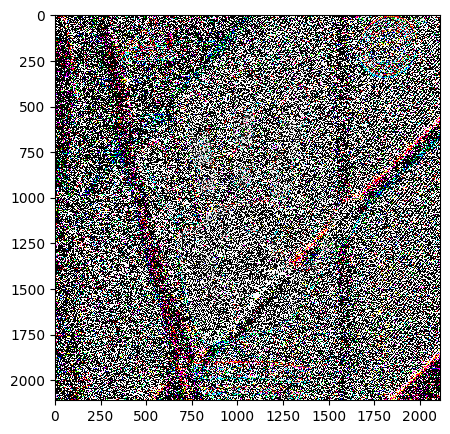

In [105]:
ii=1
plt.imshow( tshirt[ii:] - tshirt[:-ii] )

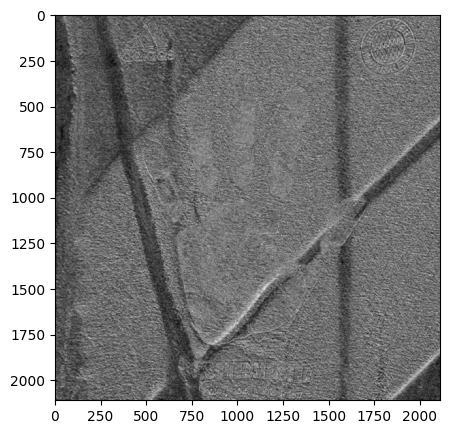

In [111]:
ii=1
plt.imshow( ndimage.gaussian_filter(tshirt[ii:] - tshirt[:-ii], 3) )

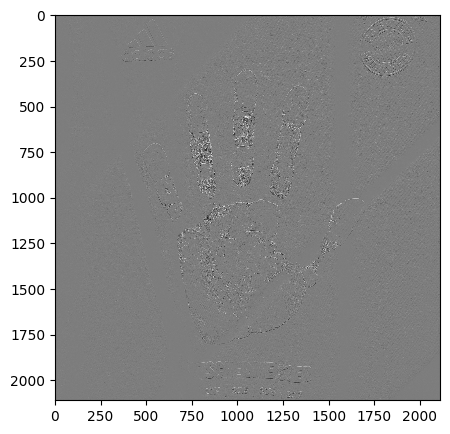

In [106]:
plt.imshow( tshirtLum[ii:] - tshirtLum[:-ii] )

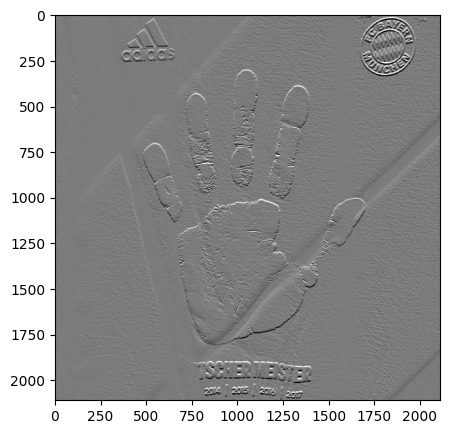

In [110]:
plt.imshow( ndimage.gaussian_filter(tshirtLum[ii:] - tshirtLum[:-ii], 3))

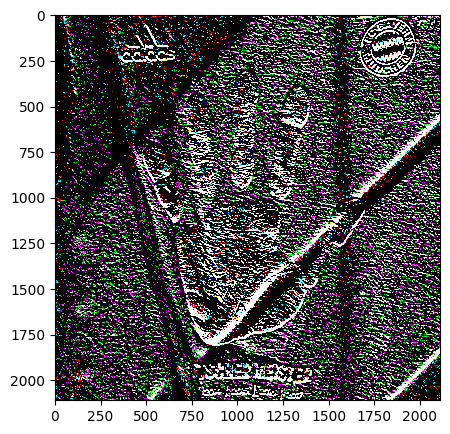

In [107]:
plt.imshow( tshirtGau[ii:] - tshirtGau[:-ii] )

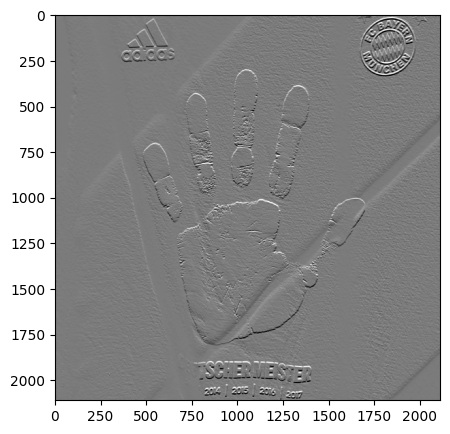

In [108]:
plt.imshow( tshirtLumGau[ii:] - tshirtLumGau[:-ii] )

In [65]:
(LumFloatGau[ii:] - LumFloatGau[:-ii]).shape

(2110, 2111)

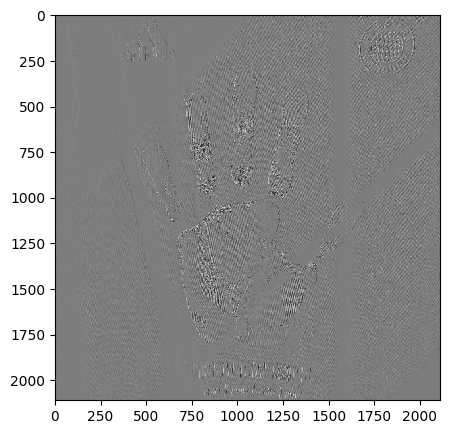

In [67]:
plt.imshow( LumFloatGau[:,ii:] - LumFloatGau[:,:-ii] )

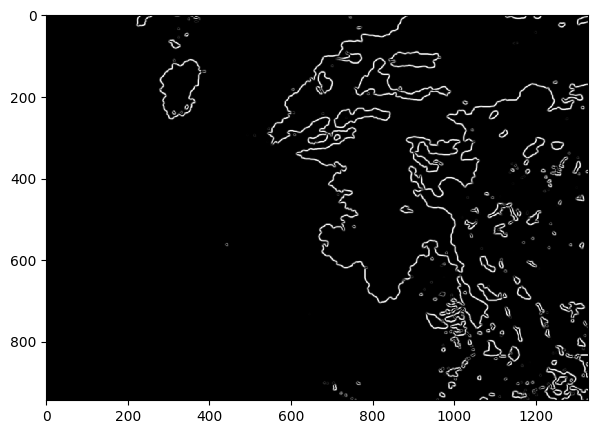

In [ ]:
plt.imshow( (LumFloatGau[ii:] - LumFloatGau[:-ii])[:,:-1]**2 + (LumFloatGau[:,ii:] - LumFloatGau[:,:-ii])[:-1]**2 )

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

In [ ]:
sy

array([[ 1,  2,  1],
       [ 0,  0,  0],
       [-1, -2, -1]])

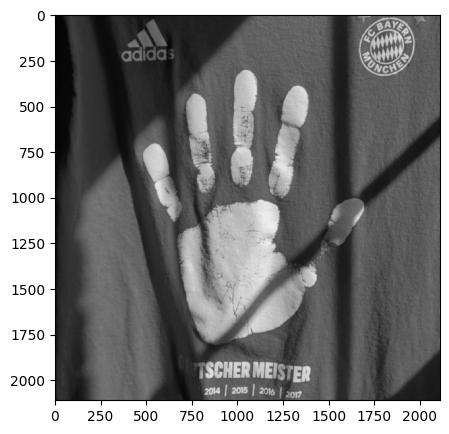

In [92]:
plt.imshow(tshirtGau)

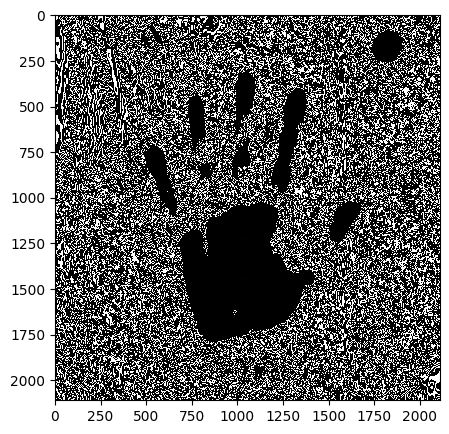

In [100]:
plt.imshow(tshirtGau[...,1] - tshirtGau[...,0])